In [1]:
import os
from astropy.table import Table
import pickle

In [2]:
file_dir='./temp/hsc_test/' #directory where files for corr_pc will be placed. I recommend using full path rather than relative path as here.
file_name='hsc_test'  #prefix to be appended to the files being saved. Should be different for different datasets.

os.makedirs(file_dir,exist_ok=True)

In [3]:
from astropy.cosmology import Planck15 as cosmo
cosmo_h=cosmo.clone(H0=100)

In [4]:
#this is cosmology table, passed inside inp file with distances keyword. order of columns matter
z=np.linspace(0,5,5001)
H_z=cosmo_h.H(z).value
D_A=cosmo_h.angular_diameter_distance(z).value
D_C=cosmo_h.comoving_transverse_distance(z).value
D_M=cosmo_h.luminosity_distance(z).value
D_Z = (z,H_z,D_A,D_C,D_M)
D_Z=np.column_stack(D_Z)
np.savetxt('./temp/Distances_planck15.dat', D_Z)

In [5]:
""" this function generates the input file for corr_pc
 corr_pc takes two samples to compute cross correlations. 
 Shape sample: Sample of galaxies with shapes. For density correlations it is not necessary to pass shapes. 
               Prefix of filenames for this sample should be passed vias file_nameS
 Density sample: Sample of galaxies/particles that trace density field. For density correlations it is not necessary to pass shapes. 
                 If shapes are passed for this sample, w++ can be computed. Prefix of filenames for this sample should be passed vias file_nameD.
                 If auto correlation is to be computed, simply set file_nameD=file_nameS.
 file_name: This is the prefix corr_pc will use to save the output files containing two point correlations. Input file to be passed to corr_pc is 
            also saved with this name. input file is saved in file_dir and the outputs are saved in new directory, file_dir+corr_data_out.
 corr: two point correlation to be computed. This should be density-density (wgg,wmm), shape-density (wg+) or shape-shape(w++). 
        When computing wg+, corr_pc will also compute and save wgg by default since pair counting is done anyways. 
        When doing w++, wg+ and wgg are also computed and saved.
 n_shape, n_density: number of galaxies in the shape sample and density sample respectively.
 do_jk: Whether to do jackknifing or not.
 njk: number of jackknife regions. jackknife regions are assumed to be labelled from 0...njk-1.
"""
def inp_gen(file_dir,file_name,file_nameS,file_nameD,corr=1,n_shape=0,n_density=0,njk=100,do_jk=1):
    s=""
    s=s+"which_corr     "+str(corr)+"\n" #0: density-density, 1: ia or WL: shape-density, 2 ia:shape-shape
    s=s+"coordinates    3"+"\n"  #0: rp-pi, 3: rp
    s=s+"estimator      4"+"\n"  #0:landy-szalay (LS): cross. works for both auto and cross correlations. For auto, pass same filenames for shape and density samples 
                                 # 1: LS:auto, for auto correlation only
                                # 4: LS like, for mean quantities, i.e. for SD/RR like terms, we instead have SD/SD like terms.
    s=s+"data_sorted     1"+"\n"  #0: no sorting, 1:sorted by z, 2:sorted by dec (y)
    s=s+"use_comoving    1"+"\n" #use comving distances from the table
    s=s+"do_jk           "+str(do_jk)+"\n" #0: no jackknife, 1: do jackknife. jk regions must be passed in a file. are assumed to be from 0..njk-1
    s=s+"sig_crit        0"+"\n" #for weak lensing only. 0: no sig crit; 1: calc sig crit for each pair, 2: use g1 wt as sig crit

    #following passes information about shape sample
    s=s+"shape_pos       "+file_dir+file_nameS+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"shape_z         "+file_dir+file_nameS+'_z.dat'+"\n"    # z coordinate
    s=s+"shape_e         "+file_dir+file_nameS+'_e.dat'+"\n"    # e1, e2
#     s=s+"shape_wt         "+file_dir+file_nameS+'_wt.dat'+"\n"  # weights on galaxies. If no weighting, pass 0
    s=s+"shape_wt         0"+"\n"
    s=s+"shape_jk        0"+"\n"   # jackknife regions

    # following passes information about density sample
    s=s+"density_patch   0"+"\n" #for weak lensing, not important for ia, gg corrs.
    s=s+"density_pos     "+file_dir+file_nameD+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"density_z       "+file_dir+file_nameD+'_z.dat'+"\n"    # z coordinate
    s=s+"density_wt       0"+"\n"  # weights on galaxies/particles. If no weighting, pass 0
#     s=s+"density_wt       "+file_dir+file_nameD+'_wt.dat'+"\n"  # weights on galaxies/particles. If no weighting, pass 0
    s=s+"density_jk      0"+"\n"   # jackknife regions    
    s=s+"density_e      0"+"\n"   #if doing shape-shape, this file should be passed. # e1, e2

    # following passes information about randoms corresponding to shape sample
    s=s+"Srandom_pos      0"+"\n"
    s=s+"Srandom_z        0"+"\n"
    s=s+"Srandoms_wt      0"+"\n"
    s=s+"Srand_jk         0"+"\n"

    # following passes information about randoms corresponding to density sample
    s=s+"Drandom_patch    0"+"\n"
    s=s+"Drandom_pos      0"+"\n"
    s=s+"Drandom_z        0"+"\n"
    s=s+"Drandoms_wt      0"+"\n"
    s=s+"drand_jk         0"+"\n"

    s=s+"distances        ./temp/Distances_planck15.dat"+"\n"  #not needed for PB
    s=s+"patch_file       0"+"\n"  #not needed for PB
    s=s+"out_file         "+file_dir+"corr_data_out/"+file_name+"_"+"\n"  # prefix for the output files.
    
    os.makedirs(file_dir+"corr_data_out/",exist_ok=True) #directory where outputs are saved.
    
    s=s+"n_threads       0"+"\n"   # number of openmp threads to use. 0== use maximum available.
    s=s+"n_shape         "+str(n_shape)+"\n"  #number of galaxies in shape sample
    s=s+"n_density       "+str(n_density)+"\n"  #number of galaxies in density sample
    s=s+"n_Srand         0"+"\n"
    s=s+"n_Drand         0"+"\n"
    s=s+"rand_subsample  0"+"\n"  #subsample randoms to speed up calculations.
    s=s+"n_jk          "+str(njk)+"\n"  #number of jk regions. regions are assumed to be labelled from 0....njk-1
    s=s+"n_patch         0 "+"\n"#not needed for PB/HSC

    s=s+"binR_min        0.1"+"\n"  # rp_min for the bins
    s=s+"binR_max       10"+"\n" # rp_max for the bins
    s=s+"n_bins         10"+"\n" #number of rp bins to use
    s=s+"lin_bin         0"+"\n"  #linear or log bins. 0: log, 1:linear
    s=s+"n_p_bin         1"+"\n"  #number of pi bins to use.. for WL leave to 1.
    s=s+"pmin         0"+"\n"  # pi_min (line of sight or z separation)
    s=s+"pmax         0"+"\n"   # pi_max (line of sight or z separation)
    s=s+"z_min         0"+"\n"    
    s=s+"z_max         4"+"\n" 
    s=s+"dz            0.001"+"\n" #resolution of cosmology table.
    s=s+"z_sep_min     -100"+"\n"  
    s=s+"z_sep_max     100"+"\n"   
    s=s+"periodic_box  0"+"\n"
    s=s+"box_size     0"+"\n"  #size of the box.

    fil=open(file_dir+file_name+'.inp','w')
    fil.write(s)


In [6]:
hsc_dir='/hildafs/projects/phy200017p/ztq1996/ztq1996/hsc/'

In [7]:
S_dat_name='r025_rot00_zbin2.fits'

In [8]:
from astropy.io import fits

In [9]:
with fits.open(hsc_dir+S_dat_name) as f:
    data=f[1].data
    print(data)
    S_dat=Table(data)

[( 8279,     2, 36411452835235108,  30.62002, -6.376178,  0.5943237 , -0.07674798, 0.00756096,  0.00193293, -0.00612652, 4.789851, 0.714 )
 ( 8279,     3, 36411452835235125,  30.61326, -6.375836,  0.89743423,  0.3828571 , 0.00789049, -0.00303394, -0.00149775, 3.258304, 0.3827)
 ( 8279,     4, 36411452835235146,  30.62137, -6.37493 ,  0.13051362,  0.80013806, 0.00694159,  0.0030251 , -0.00234604, 5.383868, 0.6425)
 ...
 (16011, 32831, 70418247970748448, 247.1476 , 44.33325 ,  0.7923786 ,  0.10393251, 0.00550792,  0.00336679,  0.00675744, 5.18838 , 0.7885)
 (16011, 32834, 70418247970748684, 247.1574 , 44.338   , -0.6247564 , -0.24049284, 0.01167254,  0.00215797,  0.00726533, 5.601186, 0.8664)
 (16011, 32835, 70418247970748695, 247.1489 , 44.33728 ,  0.32006502, -0.32866257, 0.00719187,  0.00081219,  0.00230956, 5.949475, 0.6425)]


In [10]:
S_dat['z']=S_dat['z_source_mock']
S_dat['ra']=S_dat['ra_mock']
S_dat['dec']=S_dat['dec_mock']
S_dat['e1']=S_dat['e1_mock']
S_dat['e2']=S_dat['e2_mock']

S_dat.sort('z')

In [11]:
S_dat=S_dat[:int(1e4)]

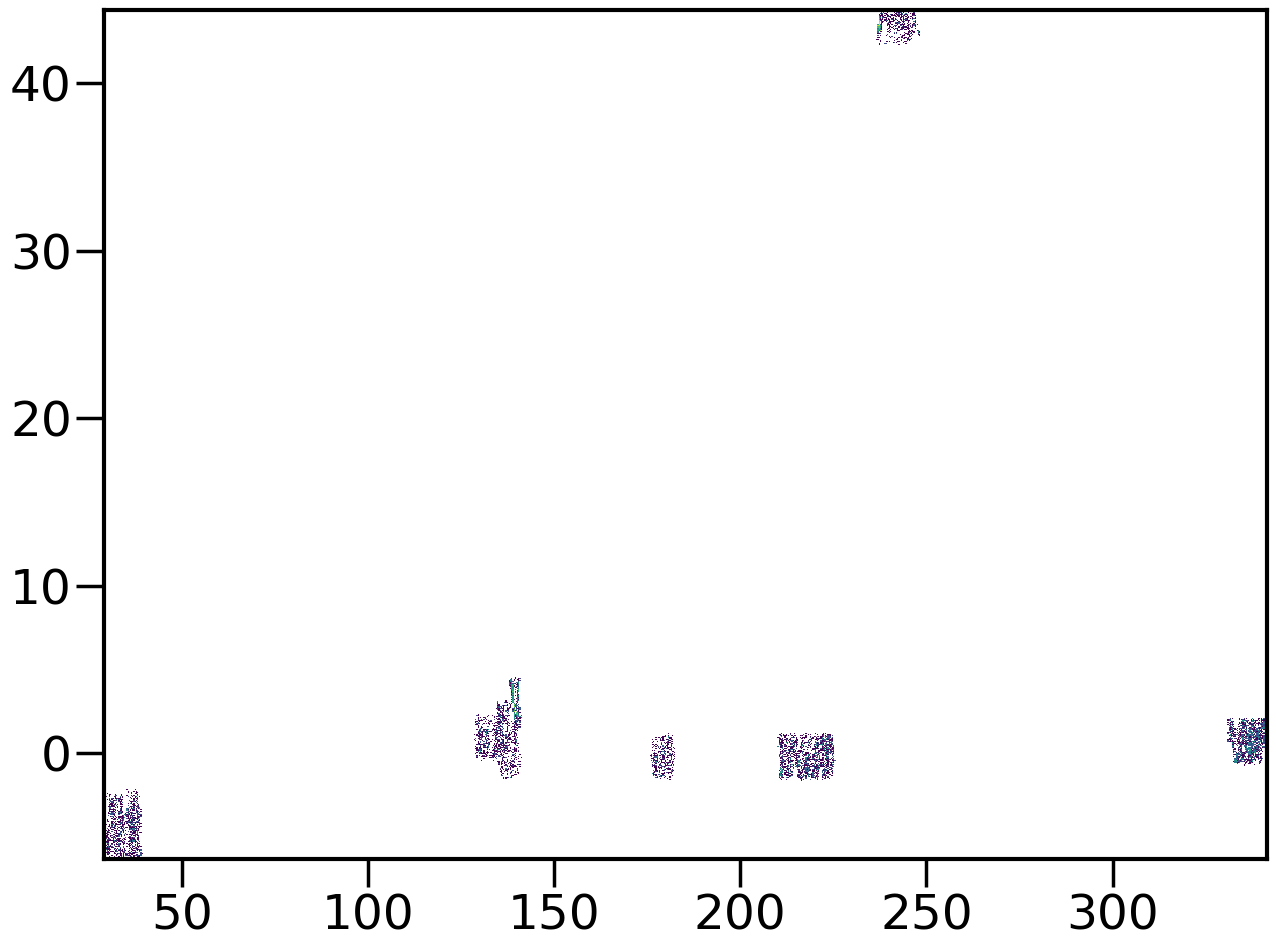

In [12]:
_=hist2d(S_dat['ra_mock'],S_dat['dec_mock'],1000,norm=LogNorm())

In [13]:
D_dat=S_dat

In [14]:
S_dat.columns

<TableColumns names=('tract_id','irow_in_original_fits_file','object_id','ra_mock','dec_mock','e1_mock','e2_mock','shear1_sim','shear2_sim','kappa','weight','z_source_mock','z','ra','dec','e1','e2')>

In [15]:
'e1' in S_dat.columns

True

In [19]:
"""
Function to write data files in format that can be read by corr_pc
"""
def write_data(data,file_name,file_dir,wt_col=None):
    file_name=file_dir+file_name
    np.savetxt(file_name+'_pos.dat',np.column_stack((data['ra'],data['dec']))) #ra,dec position of galaxies
    np.savetxt(file_name+'_z.dat',data['z']) # z position of galaxies
    if 'jk' in data.columns:
        np.savetxt(file_name+'_jk.dat',data['jk'],fmt='%i') #jackknife is read as integer
    if 'e1' in data.columns: #ellipticities. corr_pc takes e1, e2
        np.savetxt(file_name+'_e.dat',np.column_stack((data['e1'],data['e2']*-1)))
    if wt_col is not None: #wt to be applied to each galaxy/particle.
        wt=data[wt_col]*1.
        wt/=wt.mean()
        np.savetxt(file_name+'_wt.dat',wt)

In [20]:
file_nameS=file_name+'_shape'
write_data(data=S_dat,file_name=file_nameS,file_dir=file_dir,)#wt_col='mass')

# file_nameD=file_name+'_density'
# write_data(data=D_dat,file_name=file_nameD,file_dir=file_dir,wt_col='mass')
file_nameD=file_nameS

In [21]:
inp_gen(file_dir=file_dir,file_name=file_name,file_nameS=file_nameS,file_nameD=file_nameD,corr=1,n_shape=len(S_dat),n_density=len(D_dat),
        njk=0,do_jk=0) 
#corr=0 will only do wgg like correlation, no shapes. set corr=1 for wg+ and wgg